# COMP47670 Assignment 2

In [1]:
import pandas as pd
import bs4
import urllib.request as req
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## Task 1: Gathering the Data

The first step in this process is to gather the appropriate data. All the data used in this assignment was gathered from the following URL: http://mlg.ucd.ie/modules/COMP41680/assignment2/index.html.
<br><br>
This URL consists of the titles of thousands of news articles along with the categories each article belongs in and a breif snippet taken from the article. Below is a script designed to gather all this data and store it in a pandas dataframe format.

In [2]:
def gatherData(createCSV=False):
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    titles = []
    categories = []
    snippets = []
    
    for month in months:
        initial_link = f'http://mlg.ucd.ie/modules/COMP41680/assignment2/month-{month}-001.html'
        initial_response = req.urlopen(initial_link)
        initial_html = initial_response.read().decode()
        initial_soup = bs4.BeautifulSoup(initial_html, 'html.parser')
        numberOfPages = int(initial_soup.find_all('h4')[0].get_text().split('of ')[1])
        
        i = 1
        while i <= numberOfPages:
            if i <= 9:
                link = f'http://mlg.ucd.ie/modules/COMP41680/assignment2/month-{month}-00{str(i)}.html'
            
            elif i > 9:
                link = f'http://mlg.ucd.ie/modules/COMP41680/assignment2/month-{month}-0{str(i)}.html'
            
            response = req.urlopen(link)
            html = response.read().decode()
            soup = bs4.BeautifulSoup(html, 'html.parser')
        
            for title in soup.find_all('h5'):
                titles.append(title.get_text().split('\xa0')[1])
        
            for line in soup.find_all('p', {"class": "metadata"}):
                if line.get_text().split(' ')[0] == 'Category:':
                    categories.append(line.get_text().split(' ')[1])
        
            for line in soup.find_all('p', {"class": "snippet"}):
                snippets.append(line.get_text())
    
            i = i + 1
        
    assert (len(titles) == len(categories)) and (len(titles) == len(snippets))
    
    df = pd.DataFrame({'Title': titles, 'Category': categories, 'Snippet': snippets})
    
    if createCSV:
        df.to_csv('CSV_file.csv')
    
    return df

In [3]:
try:
    df = pd.read_csv('CSV_file.csv')

except:
    df = gatherData(createCSV=True)

Now that we have the full data set, we must isolate the categories we want to analyse. For the purposes of this assignment these categories are 'Sport', 'Film' and 'Music'. The following script filters out the unwanted categories from our data set.

In [4]:
myChoices = ['Sport', 'Film', 'Music']

In [5]:
def filterData(data, categories):
    df = data.copy()
    
    df = df.loc[df['Category'].isin(myChoices)].reset_index()
    
    return df[['Title', 'Snippet', 'Category']]

In [6]:
filtered_df = filterData(df, myChoices)

## Task 2: Binary Text Classification

The aim of this assignment is to use machine learning agents to make predictions and classify the categories which a number of news articles belong in based on the title and snippet associated with these articles. To complete such a task, we are first required to apply a number of pre-processing steps to our data. This includes the collection of our binary data for this binary text classification task, the lemmatisation and stemming of our input data, and the splitting of our data set into training data and testing data. The following code applies a number of preprocessing steps to our data.

In [7]:
def mergeTitleSnippet(categories, data=filtered_df):
    df = data.copy()
    
    df['TS'] = df['Title'] + ' ' + df['Snippet']
    
    df = df[['TS', 'Category']]
    
    return df

In [8]:
def Lemonize(data):
    lemmatizer = WordNetLemmatizer()
    tokenize = CountVectorizer().build_tokenizer()
    sentences = []
    
    for d in data:
        sentence = ''
        for word in tokenize(d):
            lemWord = lemmatizer.lemmatize(word)
            sentence = sentence + ' ' + lemWord
        
        sentence = sentence.lstrip()
        sentences.append(sentence)
        
    return sentences

In [9]:
def Stemonize(data):
    stemmer = PorterStemmer()
    tokenize = CountVectorizer().build_tokenizer()
    sentences = []
    
    for d in data:
        sentence = ''
        for word in tokenize(d):
            stemWord = stemmer.stem(word)
            sentence = sentence + ' ' + stemWord
        
        sentence = sentence.lstrip()
        sentences.append(sentence)
        
    return sentences

In [10]:
def preProcess(categoriesList, trainTestSplit=0.2, init_df=filtered_df):
    df = init_df.copy()
    
    df = df.loc[df['Category'].isin(categoriesList)]
    
    df = mergeTitleSnippet(categoriesList, df)
    
    X_data = df['TS']
    y_data = df['Category']
    
    X_data = list(X_data)
    y_data = list(y_data)
    
    X_data = Lemonize(X_data)
    X_data = Stemonize(X_data)
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=trainTestSplit)
    
    return X_train, X_test, y_train, y_test, categoriesList

Now it is possible to collect the necessary binary data for our binary classification problem.

In [11]:
b1_X_train, b1_X_test, b1_y_train, b1_y_test, b1Categories = preProcess(['Sport', 'Film'])
b2_X_train, b2_X_test, b2_y_train, b2_y_test, b2Categories = preProcess(['Sport', 'Music'])
b3_X_train, b3_X_test, b3_y_train, b3_y_test, b3Categories = preProcess(['Film', 'Music'])

Upon completion of the preprocessing and collection of our binary data sets, we must consider which machine learning algorithms are most suitable for the purposes of this assignment. A number of models will be evaluated in this classification problem to get a full illustration of the workings of machine learning. The algorithms being utilised are as follows:
<br><br>
* <b>Random Forrests</b> will be used to classify between 'Sport' and 'Film'
* <b>K-Nearest Neighbours</b> will be used to classify between 'Sport' and 'Music'
* <b>Naive Bayes</b> will be used to classify between 'Film' and 'Music'

Once our machine learning agents have finished training, it is important to evaluate them. The following function will be used to do just this.

In [12]:
def evaluateModel(model, true_labels, predicted_labels, categories):
    print(f'Evaluation of the {model} model\n')
    print('Classification Report:\n')
    print(classification_report(true_labels, predicted_labels))
    print('\n')
    print(f'Confusion Matrix: {model}\n')
    cm = confusion_matrix(true_labels, predicted_labels)
    cmd = ConfusionMatrixDisplay(cm, display_labels=categories)
    cmd.plot()

### Random Forests

Our first machine learning agent is the Random Forests Classifier. Additional preprocessing steps are also required to ensure the optimal performance from our machine learning agent. Firstly, a matrix must be constructed describing all the words found in the data set. Secondly, these words must be weighted based on there importance to the classification problem. By using the 'TfidfVectorizer', it is possible to do this.

In [13]:
RFpipeline = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english", ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=500))
])

In [14]:
#Train the model
RFpipeline.fit(b1_X_train, b1_y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', RandomForestClassifier(n_estimators=500))])

In [15]:
#Predict values
b1_predicted = RFpipeline.predict(b1_X_test)

Evaluation of the RandomForestClassifier(n_estimators=500) model

Classification Report:

              precision    recall  f1-score   support

        Film       0.95      0.97      0.96       343
       Sport       0.97      0.95      0.96       375

    accuracy                           0.96       718
   macro avg       0.96      0.96      0.96       718
weighted avg       0.96      0.96      0.96       718



Confusion Matrix: RandomForestClassifier(n_estimators=500)



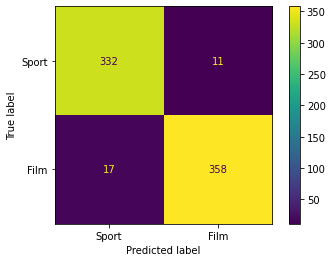

In [16]:
evaluateModel(RFpipeline['clf'], b1_y_test, b1_predicted, b1Categories)

Performance of our Random Forests Classifier is impressive with an accuracy of 95%. Our confusion matrix illustrates how only a scarce number of false negatives and false positives occur when using a Random Forests Classifier to distinguish between the cattegories of 'Sport' and 'Film'. This appears to be an acceptable algorithm with respect to the specific classification task.

### K-Nearest Neighbours

The second algorithm being considered is the K-Nearest Neighbours algorithm. Once again, the correct preprocessing steps must be carried out before training can begin.

In [17]:
KNNpipeline = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english", ngram_range=(1,2))),
    ('clf', KNeighborsClassifier(n_neighbors=15))
])

In [18]:
#Train the model
KNNpipeline.fit(b2_X_train, b2_y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', KNeighborsClassifier(n_neighbors=15))])

In [19]:
#Predict values
b2_predicted = KNNpipeline.predict(b2_X_test)

Evaluation of the KNeighborsClassifier(n_neighbors=15) model

Classification Report:

              precision    recall  f1-score   support

       Music       0.95      0.94      0.94       357
       Sport       0.94      0.95      0.94       367

    accuracy                           0.94       724
   macro avg       0.94      0.94      0.94       724
weighted avg       0.94      0.94      0.94       724



Confusion Matrix: KNeighborsClassifier(n_neighbors=15)



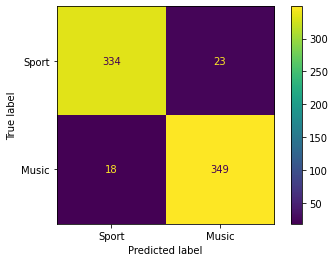

In [20]:
evaluateModel(KNNpipeline['clf'], b2_y_test, b2_predicted, b2Categories)

The performance of our K-Nearest Neighbours algorithm is also impressive reaching an accuracy of 93% however, it appears to perform marginally worse than the Random Forests Classifier. Both algorithms have been trained using different sets of data and so it may not be a fair assumption to suggest that the Random Forests Classifier outperforms the K-Nearest Neighbours algorithm for this particualr implemtation.

### Naive Bayes

The final machine learning agent being considered for binary classification is the Naive Bayes algorithm. Once again the appropriate preprocessing measures must be taken.

In [21]:
NBpipeline = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english", ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

In [22]:
#Train the model
NBpipeline.fit(b3_X_train, b3_y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', MultinomialNB())])

In [23]:
#Predict values
b3_predicted = NBpipeline.predict(b3_X_test)

Evaluation of the MultinomialNB() model

Classification Report:

              precision    recall  f1-score   support

        Film       0.93      0.96      0.94       369
       Music       0.95      0.92      0.94       345

    accuracy                           0.94       714
   macro avg       0.94      0.94      0.94       714
weighted avg       0.94      0.94      0.94       714



Confusion Matrix: MultinomialNB()



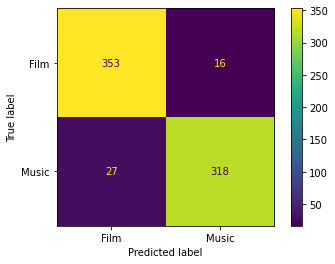

In [24]:
evaluateModel(NBpipeline['clf'], b3_y_test, b3_predicted, b3Categories)

At first glance it would appear that while this Naive Bayes approach is superior to the K-Nearest Neighbours algorithm, it is marginally worse than the Random Forests Classifier. However, despite having a higher rate of false negatives and false postives, one key point must be made regarding this Naive Bayes algorithm. It would be expected to be more difficult to distinguish between the categories of 'Music' and 'Film' when compared to the categories of 'Sport' and 'Film'. Therefore, it may be premature to suggest that the Random Forest Classifier is superior to a Naive Bayes approach for this particular scenario.

## Task 3: Multi-Class Text Classification

Similarily to what was done when considering binary classification, the data must be preprocessed to ensure it can be utilised with a machine learning agent. The functions used above can once again be used here for this preprocessing step.

In [25]:
mc_X_train, mc_X_test, mc_y_train, mc_y_test, mcCategories = preProcess(['Sport', 'Film', 'Music'])

### Random Forests

Our Random Forests Classifier appeared to perform the best when considering binary classification and so it seems like a suitable candidate to use when considering multi-class text classification. Therefore, by making use of the same pipeline used before, the Random Forests Classifier can be used for multi-class xlassification.

In [26]:
#Train the model
RFpipeline.fit(mc_X_train, mc_y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', RandomForestClassifier(n_estimators=500))])

In [27]:
#Predict values
mc_predicted = RFpipeline.predict(mc_X_test)

Evaluation of the RandomForestClassifier(n_estimators=500) model

Classification Report:

              precision    recall  f1-score   support

        Film       0.92      0.90      0.91       335
       Music       0.90      0.91      0.91       352
       Sport       0.95      0.96      0.95       391

    accuracy                           0.92      1078
   macro avg       0.92      0.92      0.92      1078
weighted avg       0.92      0.92      0.92      1078



Confusion Matrix: RandomForestClassifier(n_estimators=500)



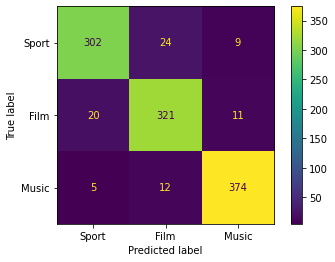

In [28]:
evaluateModel(RFpipeline['clf'], mc_y_test, mc_predicted, mcCategories)

It is clear that while an adequate accuracy has been reached with the Random Forests Classifier, it struggles to perform as well as it did in the binary classification problem. This is to be expected. The more labels a machine learning agent is required to distinguish between, the more difficult the classification task becomes.

### Naive Bayes

The Naive Bayes algorithm also performed well in the binary classification problem. Therefore, it would be of interest to constrast how a Naive Bayes machine learning agent compares to a Random Forests Classifier. By recycling the smae pipeline used in the binary classification problem, a Naive Bayes approach was used.

In [29]:
#Train the model
NBpipeline.fit(mc_X_train, mc_y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', MultinomialNB())])

In [30]:
#Predict values
mc_predicted = NBpipeline.predict(mc_X_test)

Evaluation of the MultinomialNB() model

Classification Report:

              precision    recall  f1-score   support

        Film       0.91      0.91      0.91       335
       Music       0.92      0.92      0.92       352
       Sport       0.97      0.97      0.97       391

    accuracy                           0.94      1078
   macro avg       0.94      0.94      0.94      1078
weighted avg       0.94      0.94      0.94      1078



Confusion Matrix: MultinomialNB()



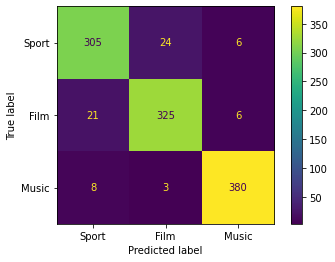

In [31]:
evaluateModel(NBpipeline['clf'], mc_y_test, mc_predicted, mcCategories)

The Naive Bayes approach clearly performs better than the Random Forests Classifier when considering multi-class classification. As the same data was used when comparing both of these algorithms, it is reasonable to suggest that the Naive Bayes algorithm may be superior for this particular implementation.